# Analysis

This notebook includes the end-to-end data analysis pipeline for predicting sales in the California cannabis market. 

Done for Project 3 in CS M148 at UCLA.

In [1]:
import pandas as pd
import numpy as np

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
import sklearn.metrics as metrics

import statsmodels.api as sm 

from matplotlib import pyplot as plt
import seaborn as sns

## Define data pipeline functions

In [2]:
def mergeTimeData(arp, totsales, totunits):
    '''Merges raw time-level data into a single clean dataframe'''
    # rename columns to match
    arp.rename(columns = {'Brands': 'Brand',
                    'vs. Prior Period': 'ARP_vsPrior'}, inplace = True)
    totsales.rename(columns = {'Total Sales ($)': 'totSales'}, inplace = True)
    totunits.rename(columns = {'Brands': 'Brand',
                            'Total Units': 'totUnits',
                            'vs. Prior Period': 'totUnits_vsPrior'}, inplace = True)
    # combine dataframes
    monthlev = arp.merge(totsales, how = 'outer', on = ['Brand', 'Months']).merge(totunits, how = 'outer', on = ['Brand', 'Months'])
    # remove rows with no information in any of the important columns
    monthlev = monthlev.dropna(subset = ['ARP', 'totSales', 'totUnits'], how = 'all').reset_index(drop = True)
    # cast columns to correct type
    # clean out commas in totUnits and totSales
    monthlev.loc[:,'totUnits'] = [x.replace(',', '') for x in monthlev.totUnits]
    monthlev.loc[:, 'totSales'] = [x.replace(',', '') if type(x) == str else np.NaN for x in monthlev.totSales ]
    monthlev = monthlev.astype({'Brand': 'str', 'ARP': 'float', 'ARP_vsPrior': 'float', 
                                'totSales': 'float', 'totUnits': 'float', 'totUnits_vsPrior': 'float'})
    monthlev.Months = pd.to_datetime(monthlev.Months)

    # compute a rolling average of sales for this brand (average of last WINDOWSIZE months' sales)
    WINDOWSIZE = 3
    monthlev_roll = pd.DataFrame()
    timecols = ['totSales', 'totUnits', 'ARP']
    brands = monthlev.loc[:,'Brand'].unique()
    for b in brands:
        mli = monthlev.loc[monthlev['Brand'] == b, :].sort_values('Months')
        for col in timecols:
            # compute rolling average column
            rollcolname = 'rolling_avg_' + col
            mli.loc[:,rollcolname] = mli.loc[:,col].rolling(WINDOWSIZE, min_periods = 1).mean()
            # shift the column so the rolling average is only from previous WINDOWSIZE months
            newroll = list(mli.loc[:,rollcolname])[0:-1]
            newroll.insert(0, np.NaN)
            mli.loc[:,rollcolname] = newroll
            # compute previous month column
            prevcolname = 'prev_month_' + col
            prevcol = list(mli.loc[:,col][0:-1])
            prevcol.insert(0, np.NaN)
            mli.loc[:,prevcolname] = prevcol
        monthlev_roll = pd.concat([monthlev_roll, mli], axis = 0, sort = False)
    
    # remove initial time point for each brand; that info is now encoded in the second time point, and they won't have a rolling average
    monthlev_roll_clean = monthlev_roll.dropna(subset = ['rolling_avg_' + c for c in timecols] + ['prev_month_' + c for c in timecols])
    monthlev_roll_clean = monthlev_roll_clean.drop(['ARP_vsPrior', 'totUnits_vsPrior'], axis = 1)
    
    return monthlev_roll_clean

In [3]:
def topX(column, x):
    '''helper for aggregateDetails: get the X most frequent values in each column we're doing topX on'''
    sortedcounts = sorted(Counter(column.dropna()).items(), 
                            key = lambda item: item[1], reverse = True)
    return([pair[0] for pair in sortedcounts[0:x]])

def topXproportion(column, topXvals):
    '''helper for aggregateDetails: get the proportions of the top X values in brand's subset of a feature'''
    thislen = len(column.dropna()) # get proportion of non-null values that are val
    if(thislen):
        props = [sum(column == val) / thislen for val in topXvals]
        props.append(1 - sum(props)) # add an other column
    else: 
        # return NA if column has none of the most common values
        props = [np.NaN] * (len(topXvals) + 1)
    return(props)

def aggregateDetails(details):
    '''Condense product-level details to aggregate statistics per brand'''
    # clean up column names
    details.rename(columns = {'Category L1': 'cat1', 'Category L2': 'cat2', 'Category L3': 'cat3', 'Category L4': 'cat4', 'Category L5': 'cat5',
                'Product Description': 'product', 'Total Sales ($)': 'totSales_2021', 'Total Units': 'totUnits_2021', 'ARP': 'ARP_2021', 
                'Items Per Pack': 'items_per_pack', 'Item Weight': 'item_weight', 'Total THC': 'tot_THC', 'Total CBD': 'tot_CBD', 'Contains CBD': 'cont_CBD', 
                'Pax Filter': 'pax_filter', 'Is Flavored': 'is_flavored', 'Mood Effect': 'mood_effect', 'Generic Vendor': 'generic_vendor', 
                'Generic Items': 'generic_items', '$5 Price Increment': 'price_inc_5dollar'}, inplace = True)
    
    # select the features decided on in develop pipeline
    keepfeat = ['cat1', 'cat2', 'cat3', 'Brand', 'product', 'items_per_pack', 
        'tot_THC', 'tot_CBD', 'cont_CBD', 'mood_effect', 'generic_vendor', 'generic_items']
    details_clean = details.loc[:,keepfeat]

    # convert binary columns to numeric
    binarycols = ['cont_CBD', 'mood_effect', 'generic_vendor', 'generic_items']
    details_clean.loc[:,'cont_CBD'] = details_clean.loc[:,'cont_CBD'].map({'Contains CBD': 1, 'THC Only': 0})
    details_clean.loc[:,'mood_effect'] = details_clean.loc[:,'mood_effect'].map({'Mood Specific': 1, 'Not Mood Specific': 0})
    details_clean.loc[:,'generic_vendor'] = details_clean.loc[:,'generic_vendor'].map({'Generic Vendors': 1, 'Non-Generic Vendors': 0})
    details_clean.loc[:,'generic_items'] = details_clean.loc[:,'generic_items'].map({'Generic Items': 1, 'Non-Generic Items': 0})
    details_clean.loc[:,binarycols] = details_clean.loc[:,binarycols].apply(pd.to_numeric)

    # convert remaining numeric columns to numeric
    makenumeric = ['tot_THC', 'tot_CBD']
    details_clean.loc[:,'tot_THC'] = [x.replace(',', '') for x in details_clean.loc[:,'tot_THC']]
    details_clean.loc[:,'tot_CBD'] = [x.replace(',', '') for x in details_clean.loc[:,'tot_CBD']]
    details_clean.loc[:,makenumeric] = details_clean.loc[:,makenumeric].apply(pd.to_numeric)

    # group on brand and aggregate details
    # define columns I want to do top X proportion aggregation on 
    topXcols = ['cat1', 'cat2', 'cat3']
    # group details on brand name
    details_grouponbrand = details_clean.groupby(['Brand'])
    NTOP = 5
    topX_percol_dict = {}
    for col in topXcols:
        topX_percol_dict[col] = topX(details_clean[col], NTOP)
    # run aggregation specific to each column
    details_agg = details_grouponbrand.agg({'cat1': lambda c: topXproportion(c, topX_percol_dict['cat1']),
                                            'cat2': lambda c: topXproportion(c, topX_percol_dict['cat2']),
                                            'cat3': lambda c: topXproportion(c, topX_percol_dict['cat3']),
                                            'items_per_pack': 'mean',
                                            'tot_THC': 'mean',
                                            'tot_CBD': 'mean',
                                            'cont_CBD': 'mean',	
                                            'mood_effect': 'mean', 
                                            'generic_vendor': 'mean',
                                            'generic_items': 'mean'})

    # convert columns of lists into separate columns
    notTopXcols = list(set(details_agg.columns) - set(topXcols))
    dta = details_agg.loc[:,notTopXcols]
    for col in topXcols:
        thisdf = pd.DataFrame(details_agg[col].tolist(), columns = topX_percol_dict[col] + ['other_' + col])
        dta = pd.concat([dta.reset_index(drop = True), thisdf.reset_index(drop = True)], axis = 1)
    dta.loc[:,'Brand'] = details_agg.index

    # add some augmented features
    dta.loc[:,'THC_cross_mood'] = dta.loc[:,'tot_THC'] * dta.loc[:,'mood_effect']
    dta.loc[:,'generic_vendor_cross_flower'] = dta.loc[:,'generic_vendor'] * dta.loc[:,'Flower']

    return(dta)


In [4]:
def combineTimeAndDetails(monthlev_roll_clean, dta):
    '''Combine merged time data and brand-aggregated details into a single clean dataframe '''
    # merge on brand
    cookies = monthlev_roll_clean.merge(dta, on = 'Brand', how = 'left')
    # remove the ~3k rows with NA remaining
    cookies = cookies.dropna()
    return cookies

## Import data and put it through the pipeline

In [5]:
arp = pd.read_csv('data/BrandAverageRetailPrice.csv')
totsales = pd.read_csv('data/BrandTotalSales.csv')
totunits = pd.read_csv('data/BrandTotalUnits.csv')
details = pd.read_csv('data/BrandDetails.csv')

In [6]:
cookies = combineTimeAndDetails(mergeTimeData(arp, totsales, totunits), 
                                aggregateDetails(details))
cookies

,Brand,Months,ARP,totSales,totUnits,rolling_avg_totSales,prev_month_totSales,rolling_avg_totUnits,prev_month_totUnits,rolling_avg_ARP,...,Sublinguals,other_cat2,Vape,Dabbable Concentrates,Pre-Rolled,Hybrid,Infused Pre-Rolled,other_cat3,THC_cross_mood,generic_vendor_cross_flower
0,#BlackSeries,2021-01-01,13.611428,9739.423400,715.532838,25352.135918,25352.135918,1616.339004,1616.339004,15.684913,...,0.0,0.0,0.0,0.000000,0.000000,0.5,0.000000,0.5,0.0,0.0
1,#BlackSeries,2021-02-01,11.873182,9102.802187,766.669135,17545.779659,9739.423400,1165.935921,715.532838,14.648170,...,0.0,0.0,0.0,0.000000,0.000000,0.5,0.000000,0.5,0.0,0.0
2,101 Cannabis Co.,2020-01-01,34.134929,11790.663567,345.413448,4465.040321,4465.040321,131.067720,131.067720,34.066667,...,0.0,0.0,0.0,0.935065,0.000000,0.0,0.064935,0.0,0.0,0.0
3,101 Cannabis Co.,2020-02-01,29.091388,20266.761007,696.658431,8127.851944,11790.663567,238.240584,345.413448,34.100798,...,0.0,0.0,0.0,0.935065,0.000000,0.0,0.064935,0.0,0.0,0.0
4,101 Cannabis Co.,2020-03-01,32.293498,30465.470533,943.393328,12174.154965,20266.761007,391.046533,696.658431,32.430995,...,0.0,0.0,0.0,0.935065,0.000000,0.0,0.064935,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23633,Zkittlez,2021-03-01,39.352005,30241.899130,768.497040,6116.791592,3848.649409,111.146389,61.006881,55.554205,...,0.0,0.0,0.0,0.533333,0.466667,0.0,0.000000,0.0,0.0,0.0
23634,Zkittlez,2021-04-01,39.387355,35209.055568,893.917749,14584.506270,30241.899130,331.358823,768.497040,53.717689,...,0.0,0.0,0.0,0.533333,0.466667,0.0,0.000000,0.0,0.0,0.0
23635,Zkittlez,2021-05-01,40.463240,25006.899159,618.015240,23099.868036,35209.055568,574.473890,893.917749,47.274952,...,0.0,0.0,0.0,0.533333,0.466667,0.0,0.000000,0.0,0.0,0.0
23636,Zkittlez,2021-06-01,38.295832,15835.402614,413.501985,30152.617952,25006.899159,760.143343,618.015240,39.734200,...,0.0,0.0,0.0,0.533333,0.466667,0.0,0.000000,0.0,0.0,0.0


### Split off labels and define scaling method

In [7]:
# needs to be sorted on month to do time series CV later
cookies = cookies.sort_values(by = 'Months')

In [8]:
cookies_y = cookies.loc[:,'totSales']
cookies_x = cookies.drop(['Brand', 'Months', 'totSales', 'totUnits', 
                        'prev_month_totSales', 'rolling_avg_totUnits', 
                        'prev_month_totUnits', 'ARP', 'prev_month_ARP'], axis = 1)

numcols = cookies_x.columns

print(cookies_x.shape)
print(cookies_y.shape)

# pipeline is just standardscaler, everything is numeric
pipe = StandardScaler()

(20313, 29)
(20313,)


## Explore the cleaned, merged dataset with some basic statistics

#### Figure 1

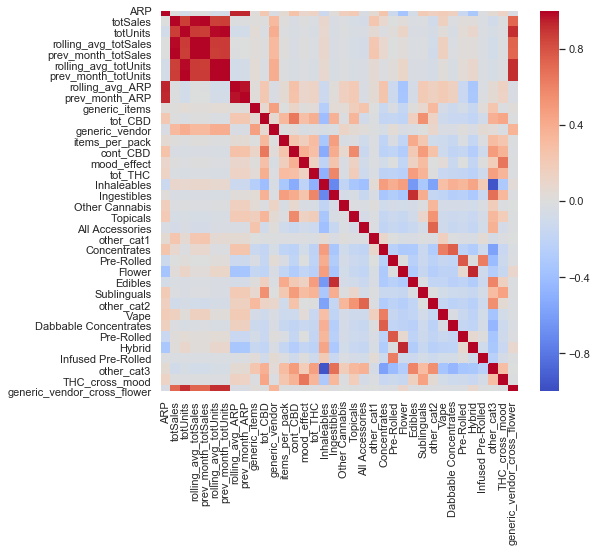

In [9]:
# correlate all the features with each other
cortable = cookies.corr(method = 'pearson')

sns.set(rc = {'figure.figsize':(8, 7)})
sns.heatmap(cortable, vmin = -1, vmax = 1, cmap = 'coolwarm', 
            xticklabels = True, yticklabels = True)

In [10]:
# find features most highly correlated with sales/units
print(cortable.loc[:,'totSales'].sort_values().head(10))
print(cortable.loc[:,'totSales'].sort_values().tail(10))

print(cortable.loc[:,'totUnits'].sort_values().head())
print(cortable.loc[:,'totUnits'].sort_values().tail())

other_cat2           -0.087804
other_cat3           -0.086252
All Accessories      -0.065689
Topicals             -0.051829
Ingestibles          -0.035176
cont_CBD             -0.033893
tot_THC              -0.029145
Edibles              -0.027805
Infused Pre-Rolled   -0.026497
Sublinguals          -0.023020
Name: totSales, dtype: float64
Vape                           0.153533
other_cat1                     0.240451
generic_vendor                 0.313528
generic_vendor_cross_flower    0.719664
rolling_avg_totUnits           0.865416
prev_month_totUnits            0.867671
totUnits                       0.874069
rolling_avg_totSales           0.990862
prev_month_totSales            0.993192
totSales                       1.000000
Name: totSales, dtype: float64
rolling_avg_ARP   -0.080241
ARP               -0.078492
prev_month_ARP    -0.078354
other_cat2        -0.057762
other_cat3        -0.053354
Name: totUnits, dtype: float64
rolling_avg_totSales           0.875550
generic_vendor_cr

## Run standard models

In [11]:
def regression_results(y_true, y_pred):
    '''function to get model performance'''
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    return {'explained_variance': round(explained_variance, 4), 
            'r2': round(r2, 4), 
            'MAE': round(mean_absolute_error, 4), 
            'MSE': round(mse, 4), 
            'RMSE': round(np.sqrt(mse), 4)}

In [12]:
# generate the train/test split we'll use for all of these models

# since we want to predict the future, 
# use the most recent time points as the test set
cutoffdate = '2021-08-01'

train = cookies_x.loc[cookies['Months'] < cutoffdate]
test = cookies_x.loc[cookies['Months'] >= cutoffdate]
train_lab = cookies_y.loc[cookies['Months'] < cutoffdate]
test_lab = cookies_y.loc[cookies['Months'] >= cutoffdate]

# scale and center features
train_pipe = pipe.fit_transform(train)
test_pipe = pipe.transform(test)

print(train_pipe.shape, train_lab.shape)
print(test_pipe.shape, test_lab.shape)

(18760, 29) (18760,)
(1553, 29) (1553,)


### Linear regression

In [13]:
# get a linear regression model
linreg = LinearRegression()

# fit to training data
linreg.fit(train_pipe, train_lab)

# predict test labels
test_pred_linreg = linreg.predict(test_pipe)

# check performance
regression_results(test_lab, test_pred_linreg)

{'explained_variance': 0.9881,
 'r2': 0.9872,
 'MAE': 75054.3482,
 'MSE': 30399308802.5012,
 'RMSE': 174353.9756}

In [14]:
# find individual stats for each feature
olsmod = sm.OLS(train_lab, train_pipe) # define OLS model
olsfit = olsmod.fit() # fit model
print(olsfit.summary()) # get statistics

                                 OLS Regression Results                                
Dep. Variable:               totSales   R-squared (uncentered):                   0.910
Model:                            OLS   Adj. R-squared (uncentered):              0.910
Method:                 Least Squares   F-statistic:                              8202.
Date:                Wed, 01 Dec 2021   Prob (F-statistic):                        0.00
Time:                        15:06:53   Log-Likelihood:                     -2.7450e+05
No. Observations:               18760   AIC:                                  5.491e+05
Df Residuals:                   18737   BIC:                                  5.492e+05
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### PCA

In [ ]:
# confirm that data is centered and scaled
print(train_pipe.mean(axis = 0))
print(train_pipe.std(axis = 0))

In [15]:
NCOMP = 10

# get PCA object
pcaobj = PCA(n_components = NCOMP)

# calculate PCs
PCs = pcaobj.fit_transform(pipe.transform(cookies_x))

#### Figure 2

Text(0, 0.5, 'Proportion of variance explained')

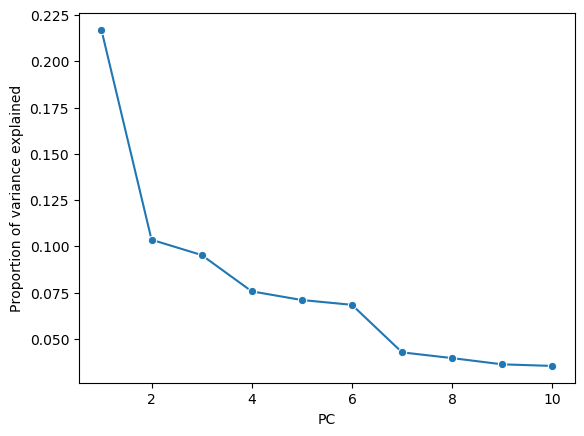

In [16]:
sns.reset_defaults()
# plot variance explained per PC
varplot = sns.lineplot(list(range(1, NCOMP+1)), 
            pcaobj.explained_variance_ratio_,
            marker = 'o')
varplot.set_xlabel("PC")
varplot.set_ylabel("Proportion of variance explained")

#### Figure 3

Text(0, 0.5, 'PC5')

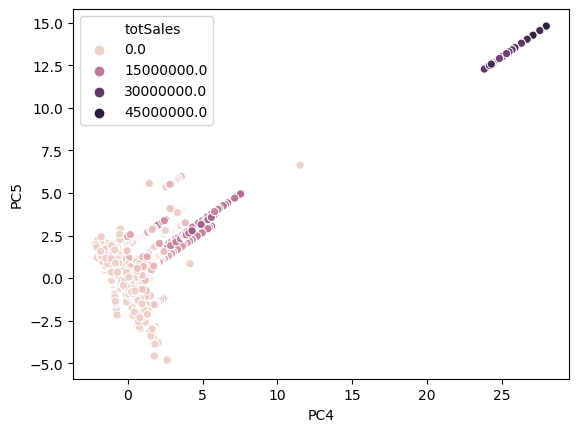

In [17]:
# plot some PCs
pcaplot = sns.scatterplot(PCs[:,4], PCs[:,5], hue = cookies_y)
pcaplot.set_xlabel("PC4")
pcaplot.set_ylabel("PC5")

### Ensemble method

In [18]:
# get a RF regressor
rfreg = RandomForestRegressor(n_estimators = 50, max_depth = 5)

# fit to train data
rfreg.fit(train_pipe, train_lab)

# predict test labels
test_pred_rfreg = rfreg.predict(test_pipe)

regression_results(test_lab, test_pred_rfreg)

{'explained_variance': 0.9848,
 'r2': 0.9839,
 'MAE': 77521.648,
 'MSE': 38254012226.3888,
 'RMSE': 195586.3293}

## K-fold cross validation

In [19]:
# since this is time series data, I will use K different cutoff points
# defining what is 'past' and what is 'future'
K_ALL = 5

tscv = TimeSeriesSplit(n_splits = K_ALL)

# verify the time series split worked correctly
for train_index, test_index in tscv.split(cookies_x):
    print("TRAIN:", train_index, "TEST:", test_index)


TRAIN: [   0    1    2 ... 3385 3386 3387] TEST: [3388 3389 3390 ... 6770 6771 6772]
TRAIN: [   0    1    2 ... 6770 6771 6772] TEST: [ 6773  6774  6775 ... 10155 10156 10157]
TRAIN: [    0     1     2 ... 10155 10156 10157] TEST: [10158 10159 10160 ... 13540 13541 13542]
TRAIN: [    0     1     2 ... 13540 13541 13542] TEST: [13543 13544 13545 ... 16925 16926 16927]
TRAIN: [    0     1     2 ... 16925 16926 16927] TEST: [16928 16929 16930 ... 20310 20311 20312]


In [20]:
# k-fold CV on the linear regression
linreg_kfold_pipe = make_pipeline(pipe, linreg)
linreg_result_kfold = cross_val_score(linreg_kfold_pipe, 
                                    cookies_x, cookies_y, cv = tscv, 
                                    scoring = 'neg_mean_squared_error')

nmse_linreg = linreg_result_kfold.mean()
print("Mean negative MSE from linear regression CV: " + str(linreg_result_kfold.mean()))

Mean negative MSE from linear regression CV: -56349722220.67122


## Grid search

In [21]:
# grid search on RF with time series cross validation
rfgrid = {'n_estimators': [1, 5, 10, 50, 100], 
            'max_depth': [1, 2, 3, 4, 5]}

gridsearch_rf = GridSearchCV(RandomForestRegressor(), rfgrid, cv = tscv, scoring = 'neg_mean_squared_error')

gridsearch_rf.fit(cookies_x, cookies_y)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=No

In [22]:
nmse_rf = gridsearch_rf.best_score_

print("Best parameters from grid search: " + str(gridsearch_rf.best_params_))
print("Best negative MSE from grid search: " + str(gridsearch_rf.best_score_))

Best parameters from grid search: {'max_depth': 5, 'n_estimators': 100}
Best negative MSE from grid search: -65214079738.974884


## Experiment with more models

### Lasso regression

In [23]:
# single fit
lassoreg = Lasso()
lassoreg.fit(train_pipe, train_lab)
test_pred_lasso = lassoreg.predict(test_pipe)
regression_results(test_lab, test_pred_lasso)

/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334516881331220.3, tolerance: 5772225505213.152
  positive)


{'explained_variance': 0.9881,
 'r2': 0.9872,
 'MAE': 72255.3887,
 'MSE': 30266469971.456,
 'RMSE': 173972.6127}

In [24]:
# x-val
lasso_kfold_pipe = make_pipeline(pipe, lassoreg)
lasso_result_kfold = cross_val_score(lasso_kfold_pipe, 
                                    cookies_x, cookies_y, cv = tscv, 
                                    scoring = 'neg_mean_squared_error')

nmse_lasso = lasso_result_kfold.mean()
print("Mean negative MSE from LASSO CV: " + str(lasso_result_kfold.mean()))

/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5687585503273.344, tolerance: 1608331007322.793
  positive)
/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144824700210131.84, tolerance: 2486474291108.579
  positive)
/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28146278901258.312, tolerance: 3429120602395.4688
  positive)
/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to i

Mean negative MSE from LASSO CV: -56349565558.83195


In [25]:
# check which features were most important, or were zeroed out
betadf = pd.DataFrame({'feature': train.columns, 
                        'beta': lassoreg.coef_})
betadf = betadf.sort_values(by = 'beta')
print(betadf.head())
print(betadf.tail())
print(betadf[betadf['beta'] == 0])

                        feature          beta
28  generic_vendor_cross_flower -19125.860146
7                   mood_effect  -7331.386936
1               rolling_avg_ARP  -4445.786807
8                       tot_THC  -2765.043037
2                 generic_items  -2548.024578
                  feature          beta
22  Dabbable Concentrates  3.635595e+03
21                   Vape  4.129247e+03
27         THC_cross_mood  6.114038e+03
14             other_cat1  1.560850e+04
0    rolling_avg_totSales  1.747930e+06
       feature  beta
20  other_cat2  -0.0


#### Figure 5

[Text(0, 0, 'generic_vendor_cross_flower'),
 Text(0, 0, 'mood_effect'),
 Text(0, 0, 'rolling_avg_ARP'),
 Text(0, 0, 'tot_THC'),
 Text(0, 0, 'generic_items'),
 Text(0, 0, 'Flower'),
 Text(0, 0, 'other_cat3'),
 Text(0, 0, 'Inhaleables'),
 Text(0, 0, 'All Accessories'),
 Text(0, 0, 'Concentrates'),
 Text(0, 0, 'Sublinguals'),
 Text(0, 0, 'cont_CBD'),
 Text(0, 0, 'generic_vendor'),
 Text(0, 0, 'other_cat2'),
 Text(0, 0, 'Topicals'),
 Text(0, 0, 'Ingestibles'),
 Text(0, 0, 'Infused Pre-Rolled'),
 Text(0, 0, 'Edibles'),
 Text(0, 0, 'tot_CBD'),
 Text(0, 0, 'Pre-Rolled'),
 Text(0, 0, 'Hybrid'),
 Text(0, 0, 'Other Cannabis'),
 Text(0, 0, 'items_per_pack'),
 Text(0, 0, 'Dabbable Concentrates'),
 Text(0, 0, 'Vape'),
 Text(0, 0, 'THC_cross_mood'),
 Text(0, 0, 'other_cat1'),
 Text(0, 0, 'rolling_avg_totSales')]

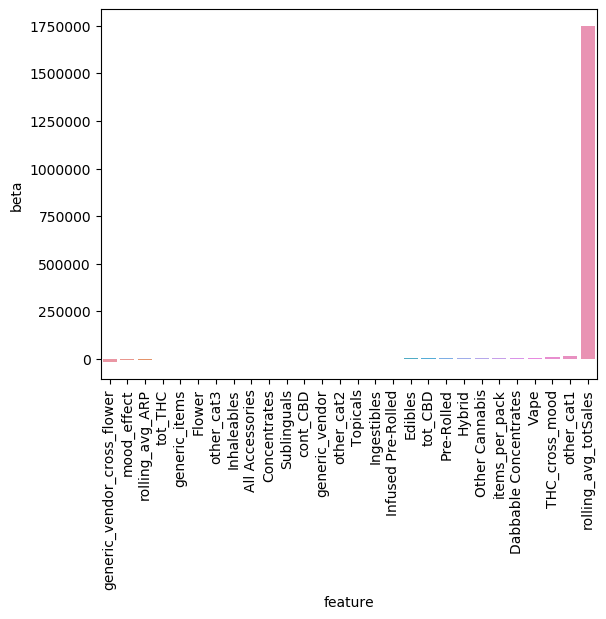

In [26]:
betaplot = sns.barplot('feature', 'beta', data = betadf)
betaplot.set_xticklabels(betaplot.get_xticklabels(),rotation = 90)

### Regression on PCs

In [27]:
# get a dataframe together with the PCs and target variable
# make sure it's sorted by month for train/test split
pcdf = pd.concat([cookies[['Months', 'Brand', 'totSales']].reset_index(drop = True), pd.DataFrame(PCs).reset_index(drop = True)], axis = 1).sort_values(by = 'Months')
pcdf # columns 0-9 are PC1-PC10

,Months,Brand,totSales,0,1,2,3,4,5,6,7,8,9
0,2018-10-01,Vet CBD,329857.741054,2.797215,0.331513,3.749931,1.057091,0.112494,-1.116979,-0.663338,4.353606,3.119711,2.756632
198,2018-10-01,ProCana (CA),219261.440893,4.174209,-0.358779,-1.821920,-1.552975,-0.554267,1.235184,-0.674077,1.067862,-0.358339,-0.591005
197,2018-10-01,Nasha Extracts,615978.497305,-1.815186,2.673122,0.007791,-0.629707,-0.235753,-0.105993,-1.433847,-0.649676,0.863546,-0.430336
196,2018-10-01,Jade Nectar,399811.383476,5.035759,0.379636,-1.421118,0.804212,0.874121,-1.203935,-0.815573,-0.311491,-0.294936,0.897722
195,2018-10-01,Dr. Kerklaan Therapeutics,255384.457981,4.255862,0.705546,2.449942,2.661091,0.961465,-2.963885,-0.371805,1.919132,-0.349626,-2.411505
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19809,2021-09-01,Clique Farming Co.,1624.752028,-1.991850,0.920543,-0.183531,-0.763589,0.011750,-0.542507,-0.996908,-0.598170,0.429390,-0.249615
19810,2021-09-01,Fruit Slabs,11671.601292,2.795208,-0.621223,-1.148614,-2.128314,-1.029215,1.755913,-0.110186,0.548376,-0.011884,-0.188776
19811,2021-09-01,Clix,6680.242886,-0.240090,-1.163514,-1.667158,2.605210,-1.436077,1.036598,1.060732,-0.585578,1.224595,-0.639434
19802,2021-09-01,Coastal Sun Cannabis,976385.483142,-1.950858,-2.153775,-0.452866,-0.944758,1.205169,-1.449520,0.150098,-0.105346,-0.198297,0.354683


In [28]:
# split PCs into one train and test set
pcdf_y = pcdf.loc[:,'totSales']
pcdf_x = pcdf.drop(['Months', 'Brand', 'totSales'], axis = 1)

train_pc = pcdf_x.loc[pcdf['Months'] < cutoffdate]
test_pc = pcdf_x.loc[pcdf['Months'] >= cutoffdate]
train_lab_pc = pcdf_y.loc[pcdf['Months'] < cutoffdate]
test_lab_pc = pcdf_y.loc[pcdf['Months'] >= cutoffdate]

print(train_pc.shape, train_lab_pc.shape)
print(test_pc.shape, test_lab_pc.shape)

(18760, 10) (18760,)
(1553, 10) (1553,)


In [29]:
# fit an elasticnet model on the PCs
pcreg = ElasticNet()
pcreg.fit(train_pc, train_lab_pc)
test_pred_pcreg = pcreg.predict(test_pc)
regression_results(test_lab_pc, test_pred_pcreg)

{'explained_variance': 0.7558,
 'r2': 0.7536,
 'MAE': 339804.184,
 'MSE': 584640196734.8615,
 'RMSE': 764617.6801}

In [30]:
# do a cross-validation and grid search on lasso/ridge balance
grid_pc = {'l1_ratio': np.arange(0., 1., 0.1),
            'alpha': [1, 5, 10, 100]}

gridsearch_pc = GridSearchCV(ElasticNet(), grid_pc, cv = tscv, scoring = 'neg_mean_squared_error')

gridsearch_pc.fit(pcdf_x, pcdf_y)

/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2401357849054968.0, tolerance: 1473487348148.05
  positive)
/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4576568464310678.0, tolerance: 2572749070017.8306
  positive)
/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6980641668985342.0, tolerance: 3596978872552.5327
  positive)
/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to 

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1, 5, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [31]:
nmse_pc = gridsearch_pc.best_score_

print(gridsearch_pc.best_score_)
print(gridsearch_pc.best_params_)

-467910236015.063
{'alpha': 1, 'l1_ratio': 0.9}


### Neural net

In [32]:
# single fit
nn = MLPRegressor()
nn.fit(train_pipe, train_lab)
test_pred_nn = nn.predict(test_pipe)
regression_results(test_lab, test_pred_nn)

/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'explained_variance': 0.0448,
 'r2': 0.0179,
 'MAE': 386245.895,
 'MSE': 2330715775076.726,
 'RMSE': 1526668.1942}

In [33]:
# x-val grid search
grid_nn = {'hidden_layer_sizes': [10, 50, 100, 200], 
            'max_iter': [5, 10, 50, 100, 200]}

gridsearch_nn = GridSearchCV(MLPRegressor(), grid_nn, cv = tscv, scoring = 'neg_mean_squared_error')
gridsearch_nn.fit(cookies_x, cookies_y)

nmse_nn = gridsearch_nn.best_score_

print(gridsearch_nn.best_score_)
print(gridsearch_nn.best_params_)

/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't conver

-53849868167.59598
{'hidden_layer_sizes': 100, 'max_iter': 100}


## Compare all the models

#### Table 1

In [34]:
modelnames = ['linear regression', 'random forest', 'lasso', 'PC lasso', 'neural net']
allnmse = [nmse_linreg, nmse_rf, nmse_lasso, nmse_pc, nmse_nn]

modelcomp = pd.DataFrame({'model': modelnames, 'NMSE': allnmse}).sort_values(by = 'NMSE').reset_index(drop = True)
modelcomp

,model,NMSE
0,PC lasso,-4.679102e+11
1,random forest,-6.521408e+10
2,linear regression,-5.634972e+10
3,lasso,-5.634957e+10
4,neural net,-5.384987e+10


#### Figure 4

[Text(0, 0, 'PC lasso'),
 Text(0, 0, 'random forest'),
 Text(0, 0, 'linear regression'),
 Text(0, 0, 'lasso'),
 Text(0, 0, 'neural net')]

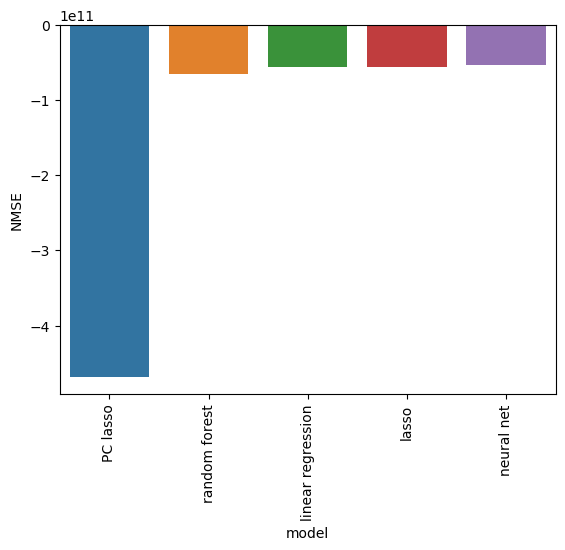

In [35]:
compplot = sns.barplot('model', 'NMSE', data = modelcomp)
compplot.set_xticklabels(compplot.get_xticklabels(),rotation = 90)